#### Diabetes


#### Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import h2o
from h2o.automl import H2OAutoML



In [57]:
# Load the data into a pandas DataFrame
data = pd.read_csv('./data/diabetes.csv')

# Display the first few rows of the DataFrame
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Count of each variable
variable_counts = data.count()
variable_counts


Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

In [4]:
# Check for null values
null_values = data.isnull().sum()

In [5]:
duplicate_rows = data.duplicated().sum()

duplicate_rows

0

In [6]:
# Count of records in the dataset
record_count = data.shape[0]

# Count of predictors (excluding the 'Outcome' column)
predictor_count = data.drop('Outcome', axis=1).shape[1]

# Print the result
print(f"The dataset contains {record_count} records and {predictor_count} predictors.")


The dataset contains 768 records and 8 predictors.


In [7]:
# Use the info() function to get a summary of the dataset
data_info = data.info()
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# Transpose the result from the describe() function for easier reading
data_description_transposed = data.describe().transpose()

data_description_transposed


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [9]:
# Redefine function to generate histograms with legends
def generate_histograms(data, display_mean=True, display_median=True):
    # Number of variables
    num_vars = data.shape[1]
    
    # Calculate number of rows needed for subplots
    num_rows = np.ceil(num_vars / 3).astype(int)
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))
    
    # Flatten axes object to iterate over
    axs = axs.flatten()
    
    # Loop over each column and plot a histogram
    for i, column in enumerate(data.columns):
        # Plot histogram
        axs[i].hist(data[column], color='gray', bins=20, alpha=0.7, label=column)
        
        # Display mean
        if display_mean:
            axs[i].axvline(data[column].mean(), color='black', linestyle='dashed', linewidth=2, label='Mean')
        
        # Display median
        if display_median:
            axs[i].axvline(data[column].median(), color='darkgray', linestyle='dashed', linewidth=2, label='Median')
        
        # Set title
        axs[i].set_title(column)

        # Add legend
        axs[i].legend()

    # Delete any unused subplots
    if num_vars % 3 != 0:
        for j in range(i+1, len(axs)):
            fig.delaxes(axs[j])

    # Show the plot
    plt.tight_layout()
    plt.show()


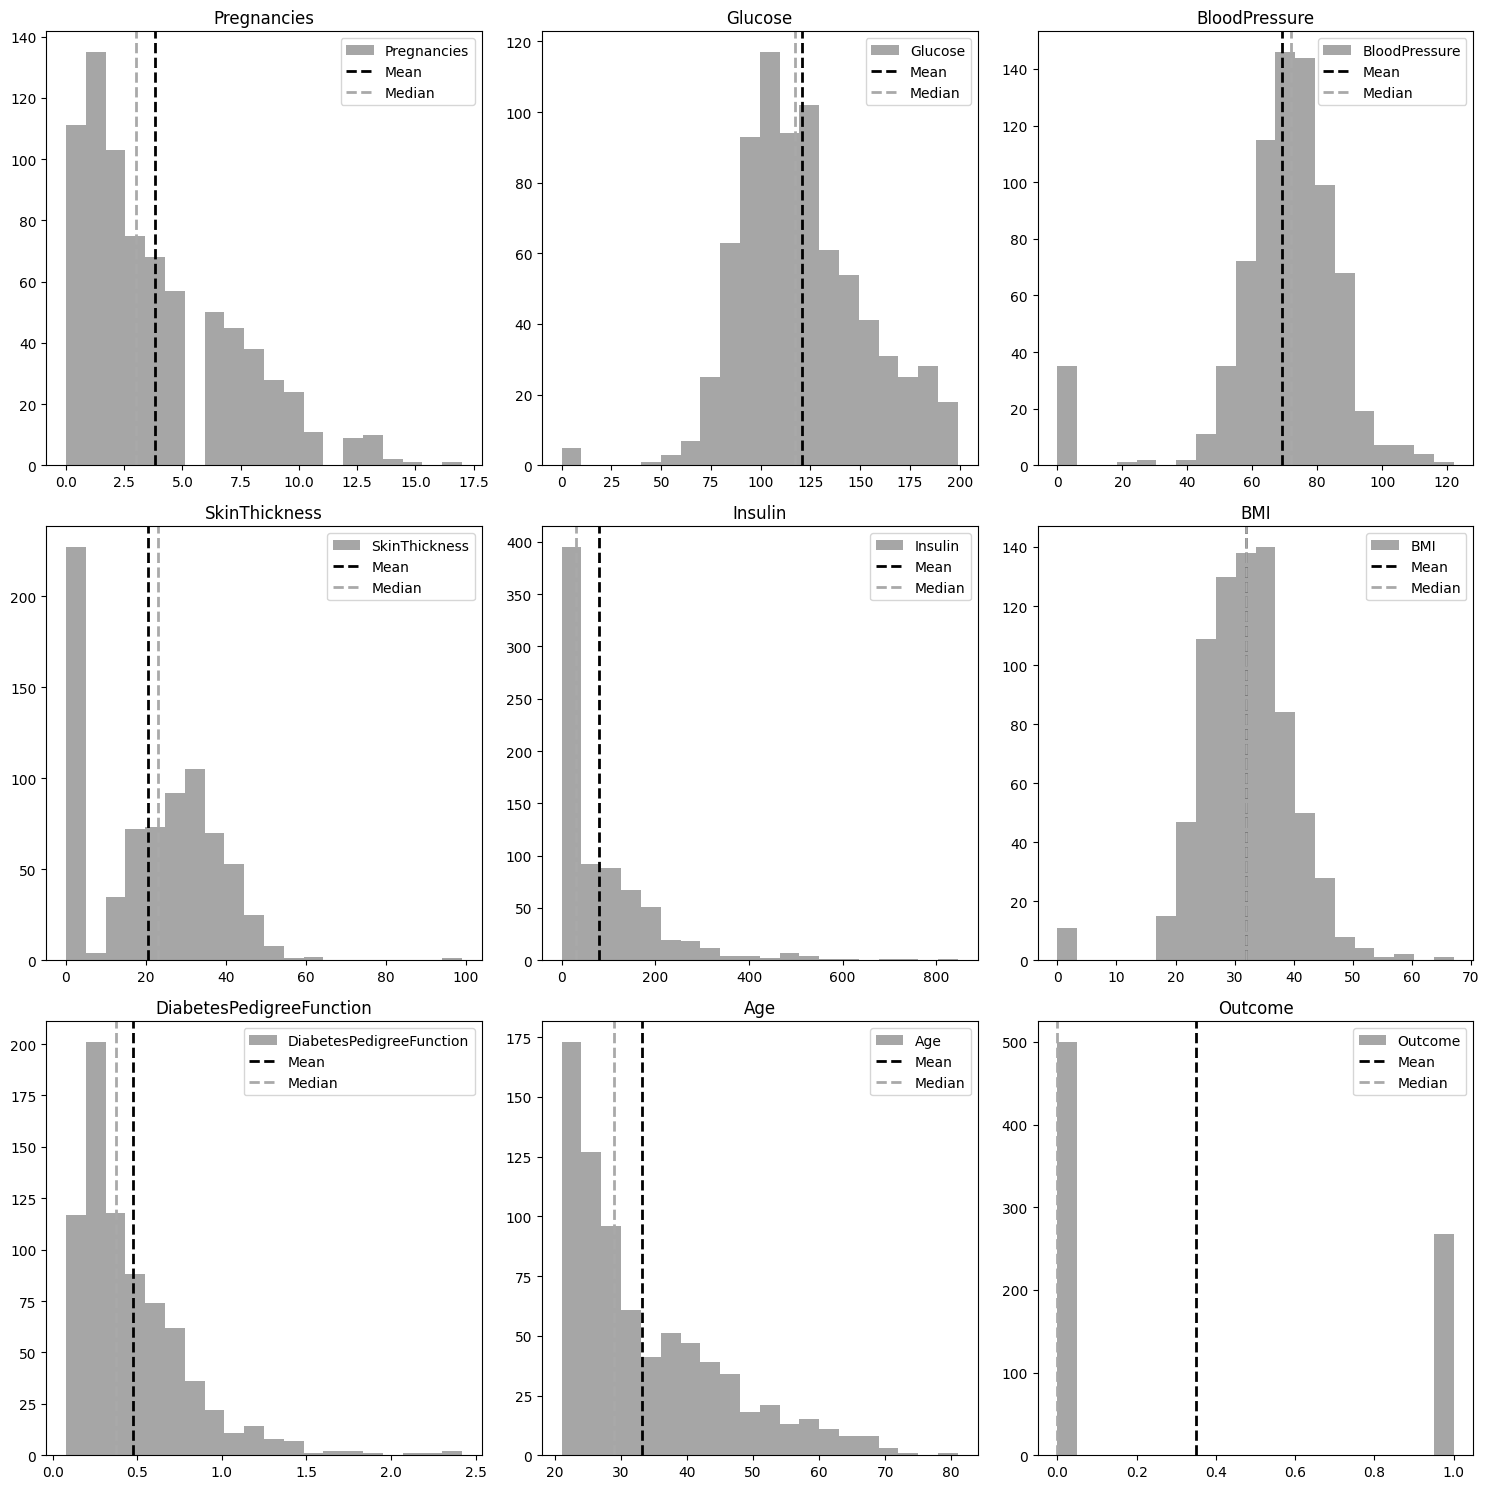

In [10]:

# Generate histograms for the dataset
generate_histograms(data)



In [11]:
# Calculate skewness for all variables except 'Outcome'
skewness = data.drop('Outcome', axis=1).skew()

# Convert to DataFrame for nicer formatting
skewness_table = pd.DataFrame(skewness, columns=['Skewness'])

skewness_table


,Skewness
Pregnancies,0.901674
Glucose,0.173754
BloodPressure,-1.843608
SkinThickness,0.109372
Insulin,2.272251
BMI,-0.428982
DiabetesPedigreeFunction,1.919911
Age,1.129597


In [58]:
# Copy the dataset
data_cleaned = data.copy()

# List of variables to clean
variables_to_clean = ['Glucose', 'BloodPressure', 'Insulin', 'SkinThickness', 'BMI']


In [59]:
# Replace null or 0 values with mean or median based on skewness
for var in variables_to_clean:
    if skewness_table.loc[var, 'Skewness'] <= 1:
        mean_value = data_cleaned[var].mean()
        data_cleaned[var] = data_cleaned[var].replace(0, mean_value)
    else:
        median_value = data_cleaned[var].median()
        data_cleaned[var] = data_cleaned[var].replace(0, median_value)

# Display the first few rows of the cleaned DataFrame
data_cleaned.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,30.5,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,30.5,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,30.5,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.0,43.1,2.288,33,1


In [14]:
# Redefine function to generate boxplots with color options
def generate_boxplots(data, group_bool=False, group_col=None, detail_bool=False):
    # Number of variables
    num_vars = data.shape[1]
    
    # Calculate number of rows needed for subplots
    num_rows = np.ceil(num_vars / 3).astype(int)
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))
    
    # Flatten axes object to iterate over
    axs = axs.flatten()
    
    # Loop over each column and plot a boxplot
    for i, column in enumerate(data.columns):
        # Plot boxplot
        if group_bool and group_col:
            sns.boxplot(x=group_col, y=column, data=data, ax=axs[i], showfliers=detail_bool, palette=['lightgray', '#FFDAB9'])
        else:
            sns.boxplot(y=column, data=data, ax=axs[i], showfliers=detail_bool, color='lightgray')
        
        # Set title
        axs[i].set_title(column)

    # Delete any unused subplots
    if num_vars % 3 != 0:
        for j in range(i+1, len(axs)):
            fig.delaxes(axs[j])

    # Show the plot
    plt.tight_layout()
    plt.show()


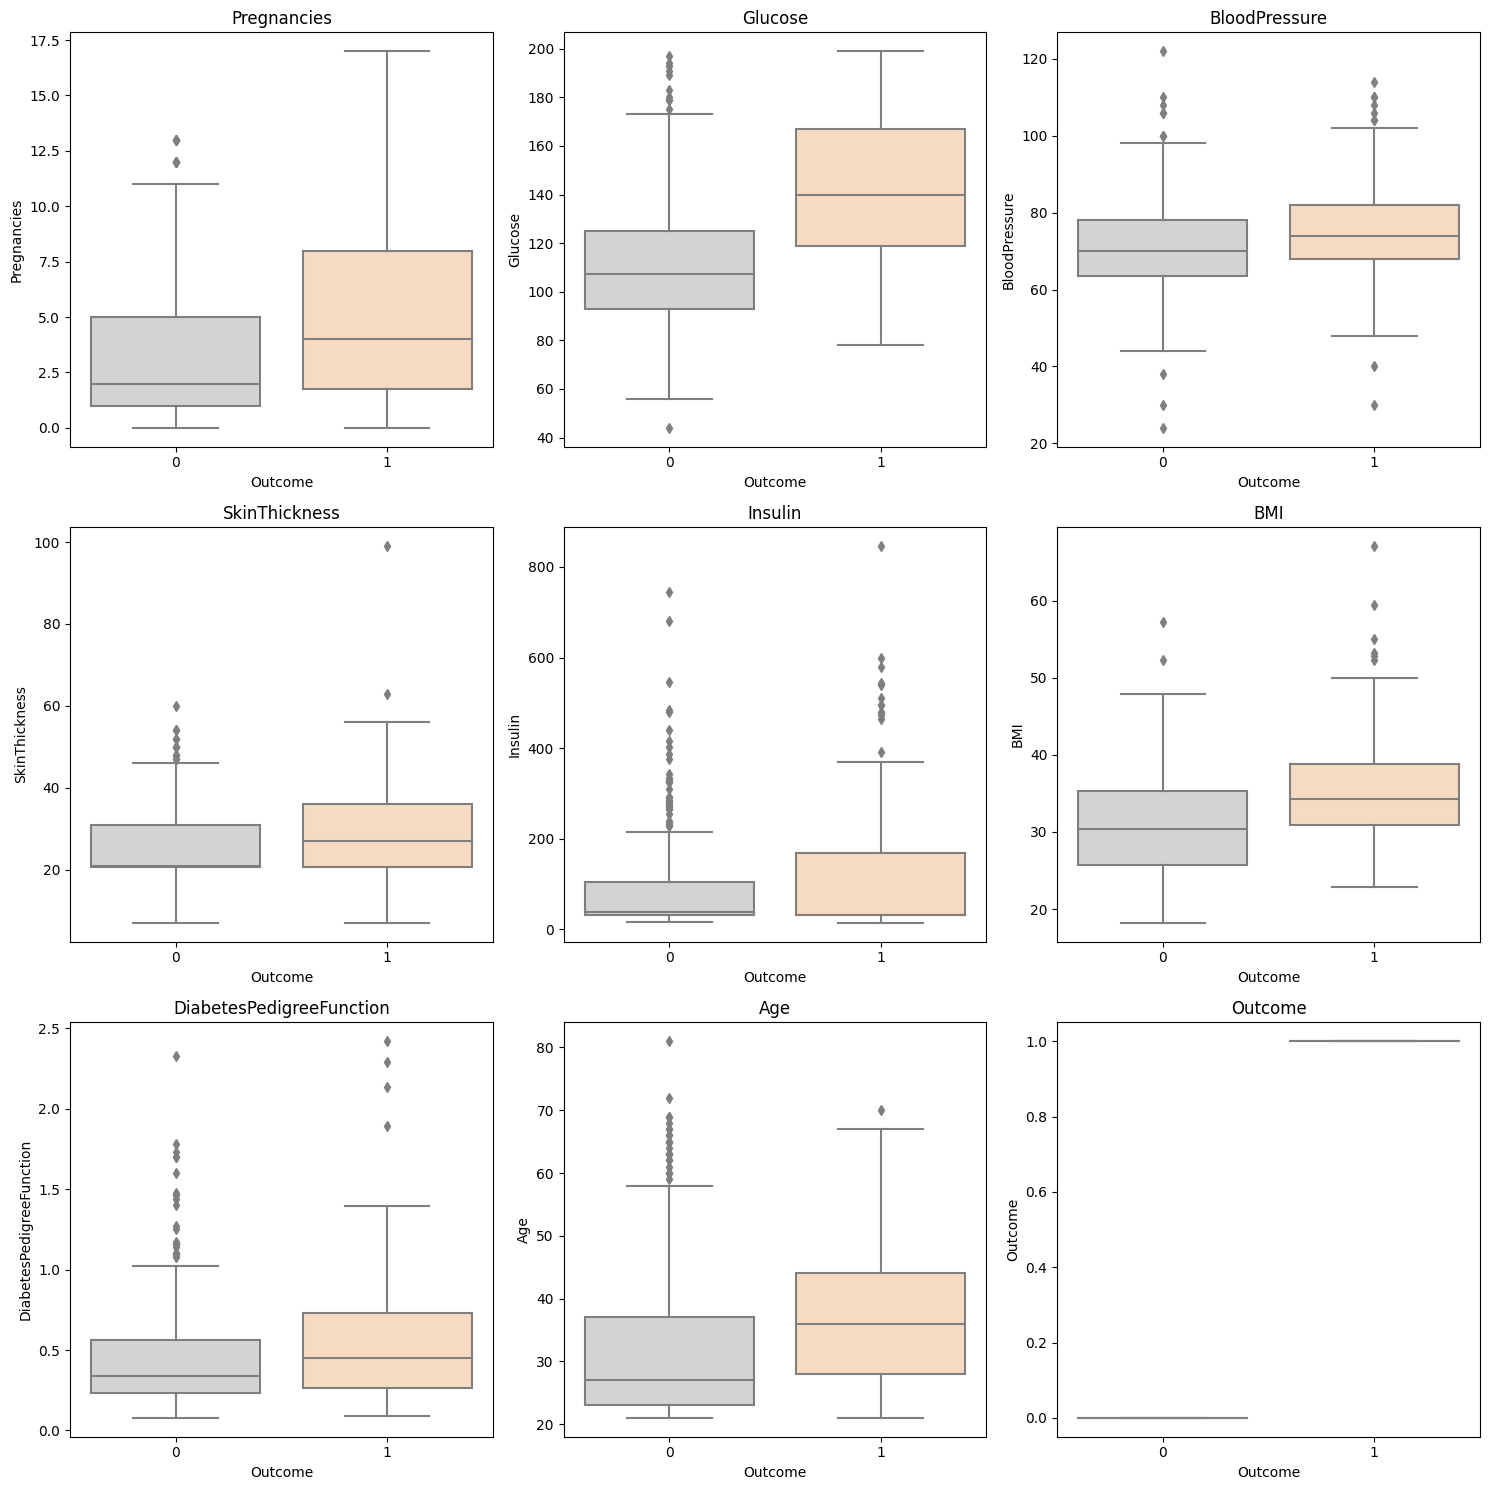

In [15]:

# Generate boxplots for the dataset
# generate_boxplots(data_cleaned)
generate_boxplots(data_cleaned, group_bool=True, group_col='Outcome', detail_bool=True)


In [ ]:
p=sns.pairplot(data_cleaned, hue = 'Outcome')

In [ ]:
# from azureml.train.automl import AutoMLConfig
# from azureml.train.automl.utilities import get_primary_metrics


# Configure an automated machine learning experiment
# The user interface provides an intuitive way to select options for your automated machine learning experiment. 
# When using the SDK, you have greater flexibility, 
# and you can set experiment options using the AutoMLConfig class, as shown in the following example.

# automl_run_config = RunConfiguration(framework='python')
# automl_config = AutoMLConfig(name='Automated ML Experiment',
#                              task='classification',
#                              primary_metric = 'AUC_weighted',
#                              compute_target=aml_compute,
#                              training_data = train_dataset,
#                              validation_data = test_dataset,
#                              label_column_name='Label',
#                              featurization='auto',
#                              iterations=12,
#                              max_concurrent_iterations=4)

# When using the SDK to run an automated machine learning experiment, you can submit the data in the following ways:

# Specify a dataset or dataframe of training data that includes features and the label to be predicted.
# Optionally, specify a second validation data dataset or dataframe that will be used to validate the trained model. 
# if this is not provided, Azure Machine Learning will apply cross-validation using the training data.
# Alternatively:

# Specify a dataset, dataframe, or numpy array of X values containing the training features, 
# with a corresponding y array of label values.
# Optionally, specify X_valid and y_valid data asset, dataframes, or numpy arrays of X_valid values to be used for validation.



# Specify the primary metric
# One of the most important settings you must specify is the primary_metric. 
# This is the target performance metric for which the optimal model will be determined. 
# Azure Machine Learning supports a set of named metrics for each type of task. 
# To retrieve the list of metrics available for a particular task type, 
# you can use the get_primary_metrics function as shown here:
# get_primary_metrics('classification')


# Submit an automated machine learning experiment
# You can submit an automated machine learning experiment like any other SDK-based experiment.
# from azureml.core.experiment import Experiment

# automl_experiment = Experiment(ws, 'automl_experiment')
# automl_run = automl_experiment.submit(automl_config)

# # Submit an automated machine learning experiment
# # You can submit an automated machine learning experiment like any other SDK-based experiment.

# from azureml.core.experiment import Experiment

# automl_experiment = Experiment(ws, 'automl_experiment')
# automl_run = automl_experiment.submit(automl_config)

# # Retrieve the best run and its model
# # You can easily identify the best run in Azure Machine Learning studio, 
# # and download or deploy the model it generated. To accomplish this programmatically with the SDK, you can use code like the following example:

# best_run, fitted_model = automl_run.get_output()
# best_run_metrics = best_run.get_metrics()
# for metric_name in best_run_metrics:
#     metric = best_run_metrics[metric_name]
#     print(metric_name, metric)

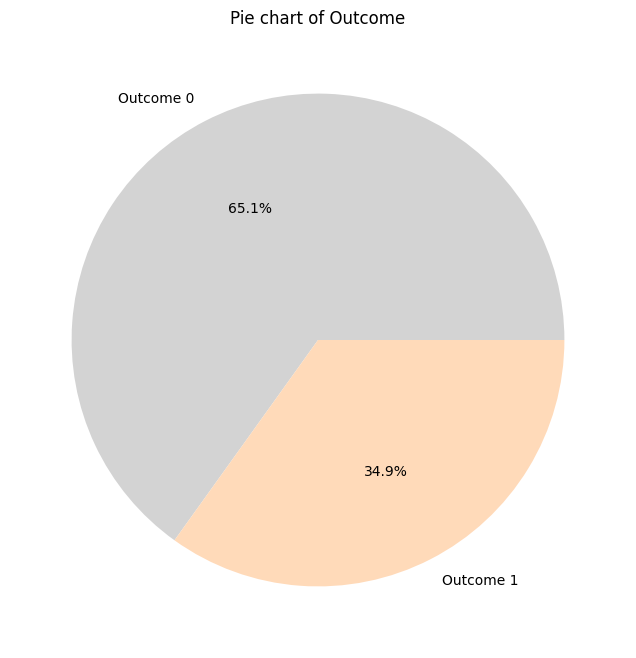

In [16]:
# Pie chart of 'Outcome'
outcome_counts = data_cleaned['Outcome'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=['Outcome 0', 'Outcome 1'], autopct='%1.1f%%', colors=['lightgray', '#FFDAB9'])
plt.title('Pie chart of Outcome')
plt.show()


#### Correlations

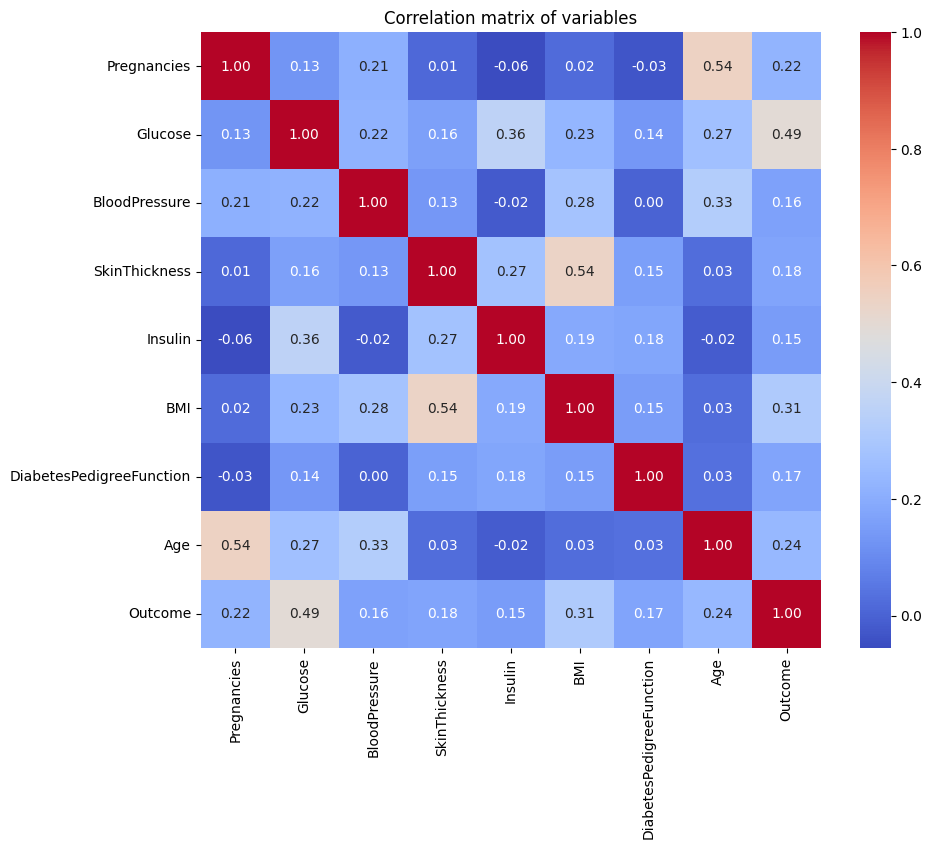

In [17]:
# Calculate correlation matrix again
corr_matrix = data_cleaned.corr()

# Move 'Outcome' to the end of the DataFrame
columns_reordered = [col for col in data_cleaned.columns if col != 'Outcome'] + ['Outcome']
corr_matrix = corr_matrix.loc[columns_reordered, columns_reordered]

# Display correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation matrix of variables')
plt.show()





In [18]:
# Create a DataFrame with all correlations
all_correlations = corr_matrix.stack().reset_index()
all_correlations.columns = ['Variable 1', 'Variable 2', 'Correlation']
all_correlations = all_correlations[all_correlations['Correlation'] != 1]  # Exclude self-correlations
all_correlations['Correlation'] = all_correlations['Correlation'].abs()  # Take absolute values

# Get the top 5 correlations
top_5_correlations = all_correlations.nlargest(5, 'Correlation')

top_5_correlations

,Variable 1,Variable 2,Correlation
7,Pregnancies,Age,0.544341
63,Age,Pregnancies,0.544341
32,SkinThickness,BMI,0.535703
48,BMI,SkinThickness,0.535703
17,Glucose,Outcome,0.492908


In [19]:
data_cleaned['Outcome'] = data_cleaned['Outcome'].astype('category')
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    float64 
 3   SkinThickness             768 non-null    float64 
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(6), int64(2)
memory usage: 49.0 KB


In [20]:
data_cleaned.to_csv('./data/data_cleaned.csv', index=False)


#### Split data

In [21]:

# Define predictors and target
X = data_cleaned.drop('Outcome', axis=1)
y = data_cleaned['Outcome']



In [22]:

# Split the dataset (70% train, 30% test), stratified by 'Outcome'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [23]:
X_train.to_csv('./data/X_train.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

In [24]:
X_train.shape
y_train.shape
print("shape of X_train:", X_train.shape)
print("shape of y_train:", y_train.shape)

shape of X_train: (537, 8)
shape of y_train: (537,)


In [25]:
X_test.shape
y_test.shape
print("shape of X_test:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_test: (231, 8)
shape of y_test: (231,)


#### Scaling

check, the code did not have fit_transform only transform on test

In [26]:

# Initialize a scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.fit_transform(X_test)

# Convert the scaled data back to DataFrames for easier handling and interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns)

# Display the first few rows of the scaled training data
X_train_scaled.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.411765,0.900709,0.612245,0.490566,0.019918,0.353783,0.120713,0.333333
1,0.352941,0.198582,0.551020,0.255405,0.019918,0.265849,0.132739,0.350000
2,0.117647,0.347518,0.408163,0.528302,0.141484,0.251534,0.586192,0.216667
3,0.117647,0.304965,0.306122,0.396226,0.122253,0.400818,0.184410,0.050000
4,0.294118,0.333333,0.510204,0.255405,0.019918,0.216769,0.030735,0.450000


In [27]:
X_train_scaled.to_csv('./data/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('./data/X_test_scaled.csv', index=False)

In [28]:
y_train.head(20)

209    1
176    0
147    0
454    0
636    0
611    1
608    0
694    0
473    0
47     0
466    0
404    1
623    0
542    1
30     0
267    0
583    0
423    0
37     1
228    0
Name: Outcome, dtype: category
Categories (2, int64): [0, 1]

In [29]:
X_train_scaled.shape
y_train.shape
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)

shape of X_train_scaled: (537, 8)
shape of y_train: (537,)


In [30]:
X_test_scaled.shape
y_test.shape
print("shape of X_test_scaled:", X_test_scaled.shape)
print("shape of y_test:", y_test.shape)

shape of X_test_scaled: (231, 8)
shape of y_test: (231,)


In [31]:
# Display the first few rows of the scaled training data
X_test_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.200000,0.554839,0.515152,0.146067,0.078125,0.247573,0.104611,0.270833
1,0.266667,0.419355,0.303030,0.382022,0.102163,0.402913,0.353117,0.104167
2,0.733333,0.638710,0.757576,0.258427,0.158654,0.446602,0.075149,0.625000
3,0.266667,0.645161,0.575758,0.247191,0.019832,0.492718,0.203245,0.333333
4,0.533333,0.393548,0.848485,0.292135,0.019832,0.609223,0.068745,0.500000


In [32]:
y_test.head(20)

730    1
198    1
24     1
417    1
387    1
156    0
660    0
205    0
3      0
531    0
158    0
347    0
224    0
756    0
425    1
185    1
78     1
428    0
247    0
471    0
Name: Outcome, dtype: category
Categories (2, int64): [0, 1]

#### AutoML

H2O's AutoML includes the following algorithms:
- Generalized Linear Model (GLM) -  This is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution.
- Random Forest (DRF) - This is H2O's implementation of the Random Forest model for distributed computing environments. Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
- Extremely Randomized Forest (XRT) - This is essentially a more randomized version of Random Forests, which are themselves an ensemble of decision trees. The randomization in XRT comes from using random subsets of the input features at each split in the decision tree, as well as using random thresholds for those splits.
- Gradient Boosting Machine (GBM) - This is an iterative ensemble method where new models are built to correct the errors made by existing models.
- Deep Learning (DeepLearning)
- Stacked Ensembles




The main reason why you see so many GBM models compared to the others is that GBM has many more hyperparameters to tune. Hyperparameters are the parameters of the model that are set before the learning process begins. As such, the grid search process—which systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance—can generate many variations of GBM models.

Random Forest and Extremely Randomized Trees have fewer hyperparameters to tune, so you see fewer variations of them. 

H2O's AutoML will attempt to train as many models as it can within the time limit you set. If the time limit is reached while some models are still being trained, those models will be stopped and will not appear in the final leaderboard. So it is possible that some models were not trained due to the time limit.

The models are trained in a specific sequence:
- Random Forest 
- Extremely Randomized Trees model 
- and a few Gradient Boosting Machines. 
- If there's enough time, it will then train a Deep Learning model, followed by a GLM.
- Finally, it will train several Stacked Ensembles. 
- If the process is stopped due to time constraints, it's the models later in the sequence that are most likely to be skipped.




AutoML internally performs cross-validation during the model training process. This means it automatically splits the data you provide into training and validation sets, and uses these to both train the models and estimate their generalization performance. The default number of cross-validation folds is 5, but you can change this with the nfolds parameter if you want.

However, it's still a good idea to hold out a test set (like X_test_scaled) before training the AutoML model, so that you can independently evaluate the final model's performance on unseen data. This helps give an unbiased estimate of how well the model is likely to perform on new data.

So the typical process would be:
- Split your full dataset into a training set and a test set.
- Use the training set with H2O's AutoML to train models and perform cross-validation.
- Take the best model from AutoML and evaluate it on the test set to estimate its performance.
- You can convert your X_train_scaled and y_train into an H2OFrame and use that for training the AutoML model. Just make sure to also transform your test set (X_test_scaled) into an H2OFrame so you can use it for evaluation later.

##### Initialize the H2O cluster
Note, I had to install java sdk x64 
https://www.oracle.com/java/technologies/downloads/#java8-windows

##### Step 1 Initialize the H2O cluster

In [33]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from C:\Users\colet\anaconda3\envs\customPy030916\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\colet\AppData\Local\Temp\tmp3m36omv7
  JVM stdout: C:\Users\colet\AppData\Local\Temp\tmp3m36omv7\h2o_TCole_started_from_python.out
  JVM stderr: C:\Users\colet\AppData\Local\Temp\tmp3m36omv7\h2o_TCole_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_TCole_z4x8sn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.406 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


##### Step 2 Initialize H2O dataframe

In [34]:
# Combine X_train_scaled and y_train into one DataFrame
y_train_series = y_train.squeeze().reset_index(drop=True)
train_df = X_train_scaled.copy().reset_index(drop=True)
train_df['Outcome'] = y_train_series

# check
train_df.to_csv('./data/train_df.csv', index=False)

# Convert to H2OFrame
hf_train = h2o.H2OFrame(train_df)

# Convert 'Outcome' to a factor
hf_train['Outcome'] = hf_train['Outcome'].asfactor()



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
# make sure Outcome is 'enum'
hf_train.types

{'Pregnancies': 'real',
 'Glucose': 'real',
 'BloodPressure': 'real',
 'SkinThickness': 'real',
 'Insulin': 'real',
 'BMI': 'real',
 'DiabetesPedigreeFunction': 'real',
 'Age': 'real',
 'Outcome': 'enum'}

In [36]:
x = hf_train.columns
y = "Outcome"
x.remove(y)
print("x columns are:", x)
print("y is:", y)

x columns are: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
y is: Outcome


##### Step 3: Set up parameters for auto ML

In [37]:

aml = H2OAutoML(max_runtime_secs = 360, seed = 1, project_name = "diabetes_prediction", exclude_algos = ["DeepLearning", "StackedEnsemble"])


##### Step 4: Run the Auto ML
The best model was Gradient Boosting: Model Key: GBM_grid_1_AutoML_1_20230714_110255_model_271

In [38]:
aml.train(x = x, y = y, training_frame = hf_train)

AutoML progress: |
11:02:55.684: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20230714_110255_model_271


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    38                 38                          5944                   3            3            3             5             8             7.81579

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1047310002221007
RMSE: 0.3236216930647584
LogLoss: 0.3469237270395541
Mean Per-Class Error: 0.1458899923605806
AUC: 0.9306035141329259
AUCPR: 0.8888627874256972
Gini: 0.8612070282658517

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4117652772491648
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      319  31   0.0886   (31.0/350.0)
1      38   149  0.2032   (38.0/187.0)
Total  357  180  0.1285   (69.0/537.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411765     0.811989  154
max f2                       0.186409     0.857008  261
max f0point5                 0.576702     0.838972  117
max accuracy                 0.413541     0.871508  152
max precision                0.938154     1         0
max recall                   0.0932869    1         335
max specificity              0.938154     1         0
max absolute_mcc             0.411765     0.714748  154
max min_per_class_accuracy   0.352543     0.855615  181
max mean_per_class_accuracy  0.335474     0.861176  191
max tns                      0.938154     350       0
max fns                      0.938154     186       0
max fps                      0.0275321    350       399
max tps                      0.0932869    187       335
max tnr                      0.938154     1         0
max fnr                      0.938154     0.994652  0
max fpr                      0.0275321    1         399
max tpr                      0.0932869    1         335

Gains/Lift Table: Avg response rate: 34.82 %, avg score: 34.53 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0111732                   0.923273           2.87166   2.87166            1                0.929781   1                           0.929781            0.0320856       0.0320856                  187.166   187.166            0.0320856
2        0.0204842                   0.909375           2.87166   2.87166            1                0.917361   1                           0.924136            0.026738        0.0588235                  187.166   187.166            0.0588235
3        0.0316574                   0.900676           2.87166   2.87166            1                0.904569   1                           0.91723             0.0320856       0.0909091                  187.166   187.166            0.0909091
4        0.0409683                   0.893694           2.87166   2.87166            1                0.897969   1                           0.912852            0.026738        0.117647                   187.166   187.166            0.117647
5        0.0502793                   0.885702           2.87166   2.87166            1                0.889436   1                           0.908516  

#### Get the leader model
##### Deciperhing model names
GBM_grid_1: This part indicates that the model was a Gradient Boosting Machine (GBM) model and it was part of the first grid search (grid_1). Grid search is a hyperparameter optimization technique where you specify a set of possible values for different hyperparameters, and the search algorithm will train a model for every possible combination of these hyperparameters.

AutoML_1_20230714_110255: This part gives some information about the AutoML run that produced this model. The numbers seem to be a timestamp indicating when the AutoML run was started.

model_271: This part is just an identifier for the model. The number at the end is automatically generated by H2O and does not have any specific meaning. It's used to differentiate between different models in the same AutoML run.

In [46]:
lb = aml.leaderboard
full_leaderboard_df = aml.leaderboard.as_data_frame()
full_leaderboard_df.to_csv('./data/full_leaderboard_df.csv', index=False)

##### Test model

In [43]:
# Convert X_test_scaled and y_test to H2OFrame for evaluation

y_test_series = y_test.squeeze().reset_index(drop=True)
test_df = X_test_scaled.copy().reset_index(drop=True)
test_df['Outcome'] = y_test_series

# check
# test_df.to_csv('./data/test_df.csv', index=False)

# Convert to H2OFrame
hf_test = h2o.H2OFrame(test_df)

# Convert 'Outcome' to a factor
hf_test['Outcome'] = hf_test['Outcome'].asfactor()



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [45]:
# hf_test.types
# Get model performance on test set
perf = aml.leader.model_performance(hf_test)
print(perf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.16385568609849363
RMSE: 0.40479091652171945
LogLoss: 0.48907846935461075
Mean Per-Class Error: 0.2365432098765432
AUC: 0.8212345679012346
AUCPR: 0.7132271834382067
Gini: 0.6424691358024692

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27392596347967113
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      92   58   0.3867   (58.0/150.0)
1      7    74   0.0864   (7.0/81.0)
Total  99   132  0.2814   (65.0/231.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273926     0.694836  129
max f2                       0.158278     0.8125    153
max f0point5                 0.517789     0.655527  75
max accuracy                 0.517789     0.757576  75
max precision                0.932244     1         0
max recall                   0.056

#### Get Predictions on whole dataset
We are going to put this data into db and build chatGPT interface

In [60]:
# Define predictors and target
X_all_data = data_cleaned.drop('Outcome', axis=1)
y_all_data = data_cleaned['Outcome']

# Fit the scaler on the training data and transform both the training and test data
X_all_data_scaled = scaler.fit_transform(X_all_data)

# Convert the scaled data back to DataFrames for easier handling and interpretation
X_all_data_scaled = pd.DataFrame(X_all_data_scaled, columns=X_all_data.columns)

# Display the first few rows of the scaled training data
# X_all_data_scaled.head()

# y_all_data_series = y_all_data.squeeze().reset_index(drop=True)
# all_data_df = X_all_data_scaled.copy().reset_index(drop=True)
# all_data_df['Outcome'] = y_all_data_series

# # check
# all_data_df.to_csv('./data/all_data_df.csv', index=False)

# Convert to H2OFrame
hf_X_all_data_scaled = h2o.H2OFrame(X_all_data_scaled)

# # Convert 'Outcome' to a factor
# hf_all['Outcome'] = hf_all['Outcome'].asfactor()

hf_X_all_data_scaled.types

Parse progress: |

████████████████████████████████████████████████████████████████| (done) 100%


{'Pregnancies': 'real',
 'Glucose': 'real',
 'BloodPressure': 'real',
 'SkinThickness': 'real',
 'Insulin': 'real',
 'BMI': 'real',
 'DiabetesPedigreeFunction': 'real',
 'Age': 'real'}

In [61]:
all_predictions    = aml.leader.predict(hf_X_all_data_scaled)
all_predictions_df = all_predictions.as_data_frame()

data_cleaned_predictions = data_cleaned.copy()
data_cleaned_predictions['predict'] = all_predictions_df['predict']
data_cleaned_predictions.head(20)


gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,predict
0,6,148.0,72.000000,35.000000,30.5,33.600000,0.627,50,1,1
1,1,85.0,66.000000,29.000000,30.5,26.600000,0.351,31,0,0
2,8,183.0,64.000000,20.536458,30.5,23.300000,0.672,32,1,1
3,1,89.0,66.000000,23.000000,94.0,28.100000,0.167,21,0,0
4,0,137.0,40.000000,35.000000,168.0,43.100000,2.288,33,1,1
5,5,116.0,74.000000,20.536458,30.5,25.600000,0.201,30,0,0
6,3,78.0,50.000000,32.000000,88.0,31.000000,0.248,26,1,0
7,10,115.0,69.105469,20.536458,30.5,35.300000,0.134,29,0,0
8,2,197.0,70.000000,45.000000,543.0,30.500000,0.158,53,1,1
9,8,125.0,96.000000,20.536458,30.5,31.992578,0.232,54,1,1


In [62]:
data_cleaned_predictions.to_csv('./data/data_cleaned_predictions.csv', index=False)